In this project I will train an imgage classifier to recognize different species of flowers.

I will be using the Oxford flowers dataset.

Below are a few examples.


<img  src='assets/Flowers.png' width=500px>

The project is broken down into 3 steps:
1. Load the image dataset and create a pipeline.
2. Build and train an image classifier on the dataset.
3. Use the model to make predictions on a test set.

I will use Python and TensorFlow.

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
# Install Pytorch
!pip3 install torch torchvision torchaudio

In [158]:
# Import Torch
import torch
from torchvision import transforms, datasets, models

In [159]:
# Install TensorFlow transforms.
!pip3 install -q tensorflow-transform
import tensorflow_transform as tft

In [160]:
# Import TensorFlow.
import tensorflow as tf
import tensorflow_hub as hub 
import tensorflow_datasets as tfds

In [161]:
# Other imports.
import json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [162]:
# Matplotlib settings.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar() 

In [163]:
# Load and split the dataset.
oxford_flowers, info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)
print(oxford_flowers)

test, validation, train = oxford_flowers['train'], oxford_flowers['validation'], oxford_flowers['test']

{'test': <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'train': <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'validation': <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [164]:
# Normalize and resize all sets.
transformed_training = transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomCrop(224),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(), 
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])

transformed__validation = transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(0.485, 0.456, 0.406),
                                                                  (0.229, 0.224, 0.225)])

transformed_test = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225)])


In [165]:
# Explore the dataset.

# Print number of examples in each set.
print("Number of examples in training set:", len(train))
print("Number of examples in validation set:", len(validation))
print("Number of examples in test set:", len(test))
print('\n')

# Print datasetinfo.
print("Dataset info:", info)
print('\n')

# Print number of classes in dataset.
print("Number of classes in dataset:", len(oxford_flowers))
print('\n')

# Display the dataset.
oxford_flowers
print(len(oxford_flowers))


Number of examples in training set: 6149
Number of examples in validation set: 1020
Number of examples in test set: 1020


Dataset info: tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(

In [166]:
# Print number of classes in dataset.
num_classes = info.features['label'].num_classes
print("The number of classes is:", num_classes)

The number of classes is: 102


In [167]:
# Print the total number of examples.
#total_num_examples = info.splits


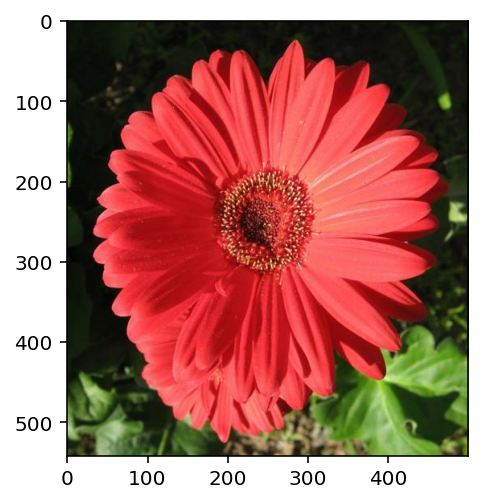

The shape of this image is: (542, 500, 3)
The label of this image is: 40


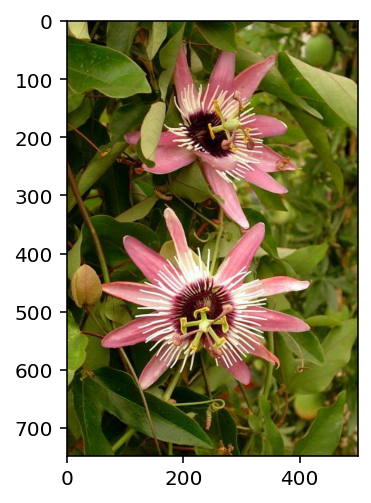

The shape of this image is: (748, 500, 3)
The label of this image is: 76


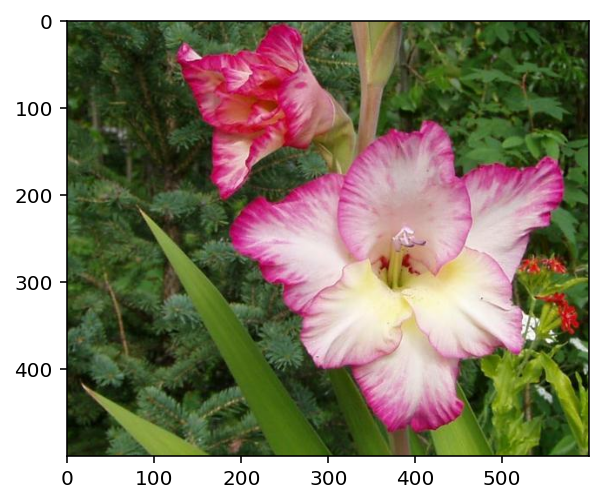

The shape of this image is: (500, 600, 3)
The label of this image is: 42


In [168]:
# Print the shape and labels of 3 train set imgages.
for image, label in train.take(3):
  image = image.numpy()
  label = label.numpy()

  plt.imshow(image)
  plt.show()

  print("The shape of this image is:", image.shape)
  print("The label of this image is:", label) 


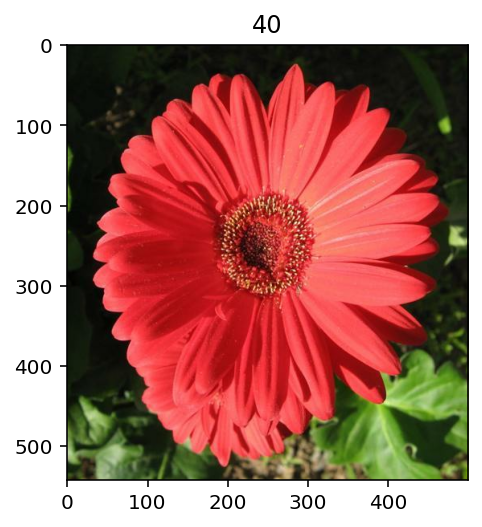

In [169]:
# Plot 1 image from train set and set the title as the image label.
for image, label in train.take(1):
  image = image.numpy()
  label = label.numpy()

  plt.imshow(image)
  plt.title(label)
                                

In [170]:
import json
from collections import OrderedDict
from numpy.ma.core import sort
from textwrap import indent
from types import TracebackType
# Map labels to category name.
#from google.colab import files
#uploaded = files.upload()

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path_to_json_file = '/content/drive/MyDrive/label_map.json'


json_file = open(path_to_json_file, 'r')
class_names = json_file.read()
json_file.close()


#print(class_names)
class_names = json.loads(class_names)
class_names
#with open('label_map.json', 'r') as f:
#  class_names = json.load(f)
#json.dumps(class_names, indent=4)  

Mounted at /content/drive


{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

In [171]:
#class_names = int(class_names)

In [172]:
# Create a pipeline for each set.
batch_size = 32
image_size = 224
total_train_examples = info.splits['train'].num_examples

def normalize(image, label):

    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255

    return image, label

training_batches = train.cache().shuffle(total_train_examples//4).map(normalize).batch(batch_size).prefetch(1)
validation_batches = validation.cache().map(normalize).batch(batch_size).prefetch(1)
test_batches = test.cache().map(normalize).batch(batch_size).prefetch(1)


In [173]:
# Download, extract features and freeze the pre-trained classifier.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
feature_extractor.trainable = False


In [174]:
# Build the model.
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dense(num_classes, activation= 'softmax')])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_5 (Dense)             (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [175]:
# Train the model using a GPU.
print("Is there a GPU available?:", tf.config.list_physical_devices('GPU'))
print('\n')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 3

history = model.fit(training_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)
                                    

Is there a GPU available?: []


Epoch 1/3
193/193 [==============================] - 201s 987ms/step - loss: 1.9206 - accuracy: 0.6066 - val_loss: 0.9924 - val_accuracy: 0.7892
Epoch 2/3
193/193 [==============================] - 176s 912ms/step - loss: 0.5359 - accuracy: 0.8993 - val_loss: 0.6528 - val_accuracy: 0.8647
Epoch 3/3
193/193 [==============================] - 175s 908ms/step - loss: 0.3088 - accuracy: 0.9496 - val_loss: 0.5434 - val_accuracy: 0.8794


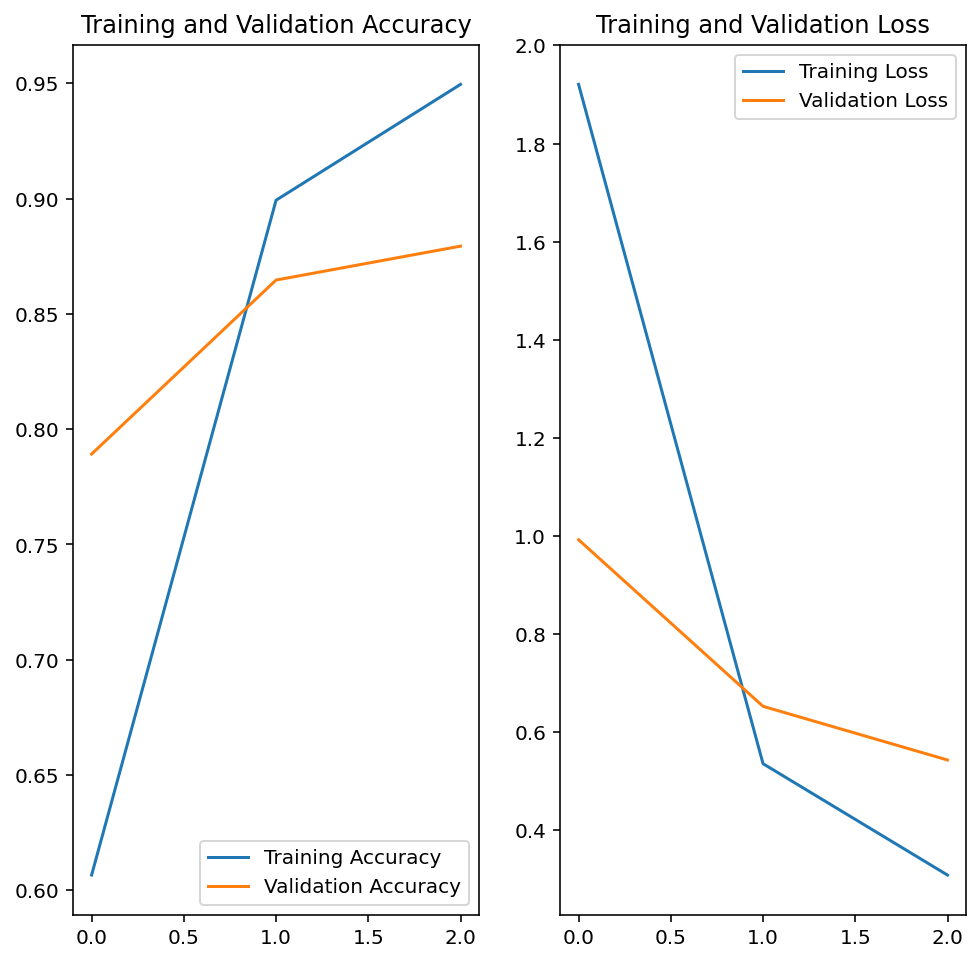

In [176]:
# Plot the loss & accuracy for the train & val sets.
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [177]:
# Test the network.
loss, accuracy = model.evaluate(test_batches)

print('\n')
print("The testing loss is: {:,.3f}".format(loss))
print("The testing accuracy is: {:.3%}".format(accuracy))

32/32 [==============================] - 26s 814ms/step - loss: 0.6023 - accuracy: 0.8402


The testing loss is: 0.602
The testing accuracy is: 84.020%


In [178]:
# Save the model as Keras.
import time
t = time.time()

saved_keras_model_filepath = './{}.h5'.format(int(t))
model.save(saved_keras_model_filepath)


In [179]:
# Load the saved Keras model.
from tensorflow import keras
import tensorflow as tf

reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={'KerasLayer':hub.KerasLayer})
reloaded_keras_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_5 (Dense)             (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [180]:
# Normalize and resize the input. 
def process_image(image):

    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255

    return image.numpy()


Mounted at /content/drive


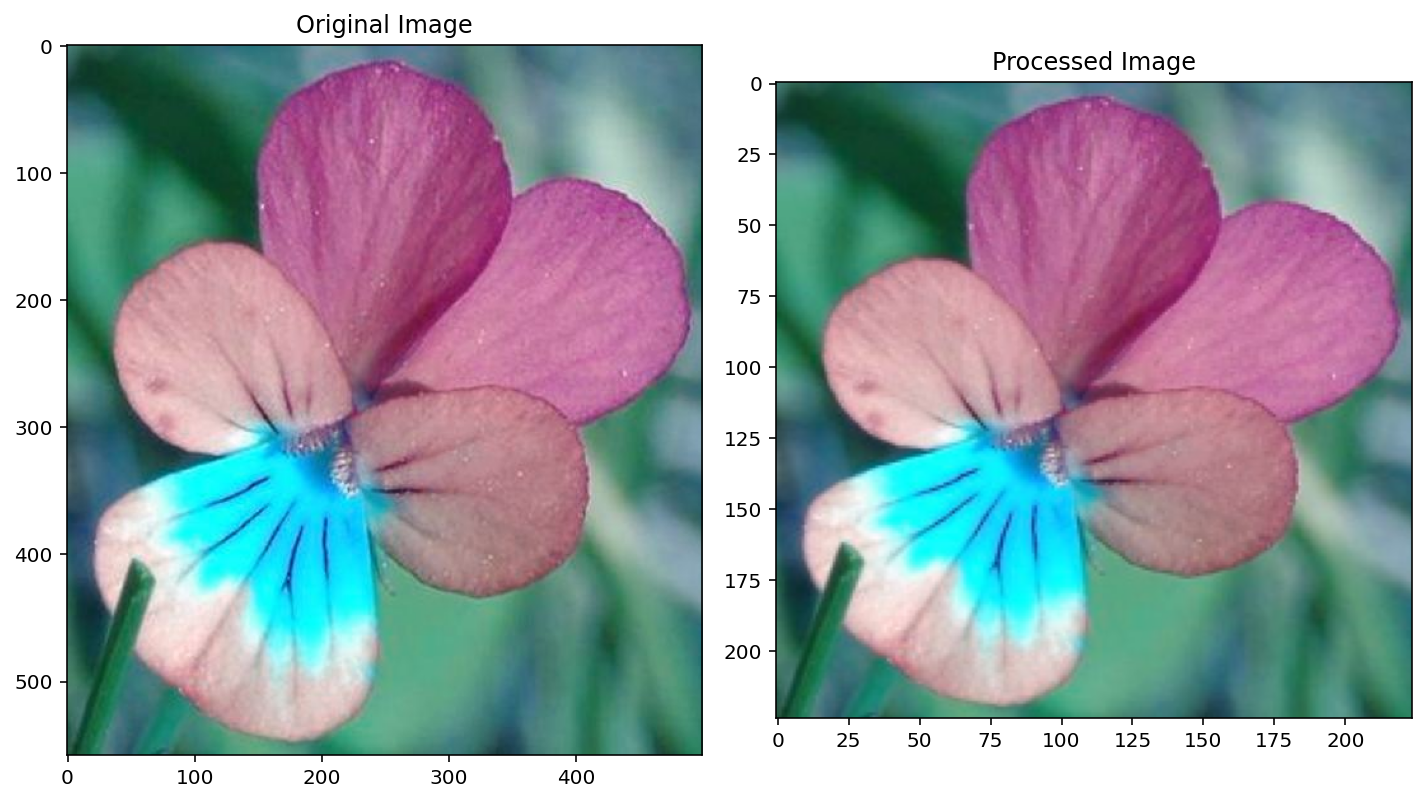

In [181]:
from IPython.core.pylabtools import figsize
# Call and verify the 'process_image' function.
import cv2
import numpy as np

#from google.colab import files
#uploaded = files.upload()

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

test_image = '/content/drive/MyDrive/wild_pansy.jpg'

img = cv2.imread(test_image)

image_path = img
test_image = image_path
test_image = np.asarray(test_image)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), ncols=2)

ax1.imshow(img)
ax1.set_title('Original Image')

ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')

plt.tight_layout()
plt.show()


In [182]:
# Make predictions.
def predict(test_images, model, top_k):

    #test_images = cv2.imread(test_images) 
    test_images = np.asarray(test_images)
    processed_test_images = process_image(test_images)
    expanded_processed_test_images = np.expand_dims(processed_test_images, axis=0)
    predictions = reloaded_keras_model.predict(expanded_processed_test_images)
    top_k_values, top_k_indices = tf.nn.top_k(predictions, k=top_k)

    top_k_values = top_k_values.numpy()
    top_k_indices = top_k_indices.numpy()

    print("The 'probs' are: ", top_k_values)
    print("The 'classes' are: ", top_k_indices)

    return top_k_values, top_k_indices


In [183]:
# Mount GDrive
import cv2
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

test_images = '/content/drive/MyDrive/test_images'
#test_images = cv2.imread(test_images)
#test_images = np.arange(30).reshape(2, 5, 3)

Mounted at /content/drive


/content/drive/MyDrive/test_images/hard-leaved_pocket_orchid.jpg
The 'probs' are:  [[9.9445623e-01 2.4562997e-03 5.0477323e-04 5.0282734e-04 3.3704829e-04]]
The 'classes' are:  [[ 1 17  5 79  6]]
Class names:
- hard-leaved pocket orchid
- peruvian lily
- tiger lily
- anthurium
- moon orchid


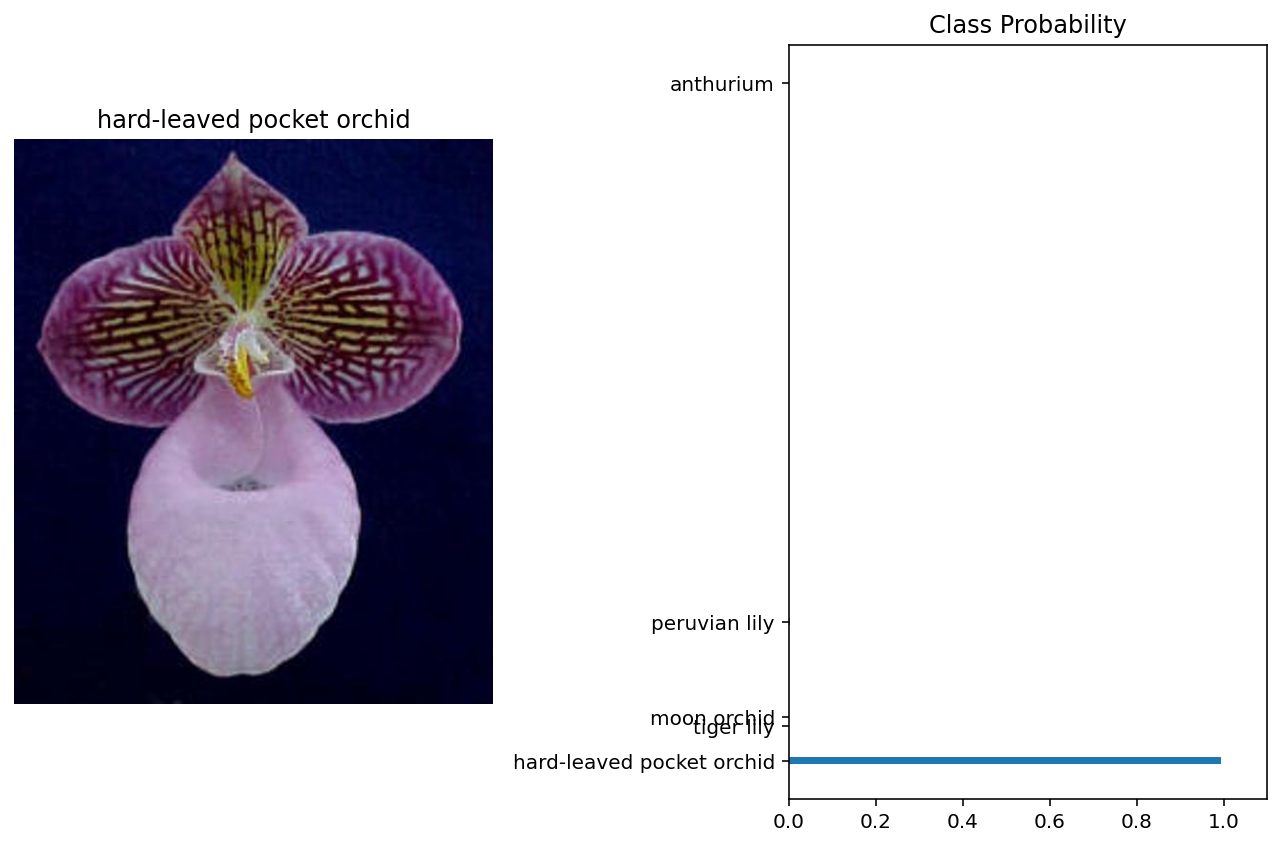

/content/drive/MyDrive/test_images/wild_pansy.jpg
The 'probs' are:  [[9.9297684e-01 9.8864676e-04 6.0666841e-04 5.8871467e-04 4.8624742e-04]]
The 'classes' are:  [[51 18 63 81 88]]
Class names:
- wild pansy
- balloon flower
- silverbush
- clematis
- watercress


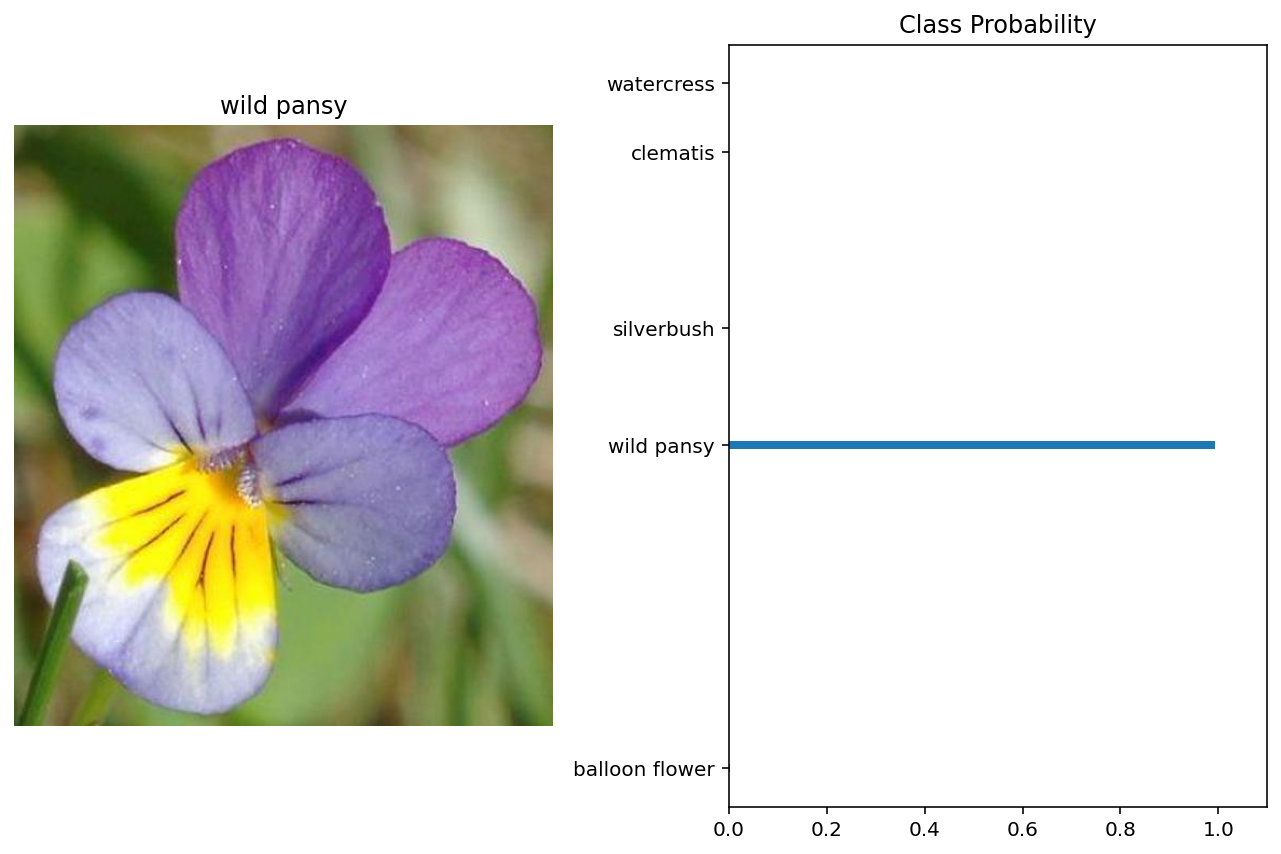

/content/drive/MyDrive/test_images/cautleya_spicata.jpg
The 'probs' are:  [[0.9451726  0.01110928 0.00477111 0.00360816 0.00297733]]
The 'classes' are:  [[60 38 23 45 36]]
Class names:
- cautleya spicata
- siam tulip
- red ginger
- wallflower
- cape flower


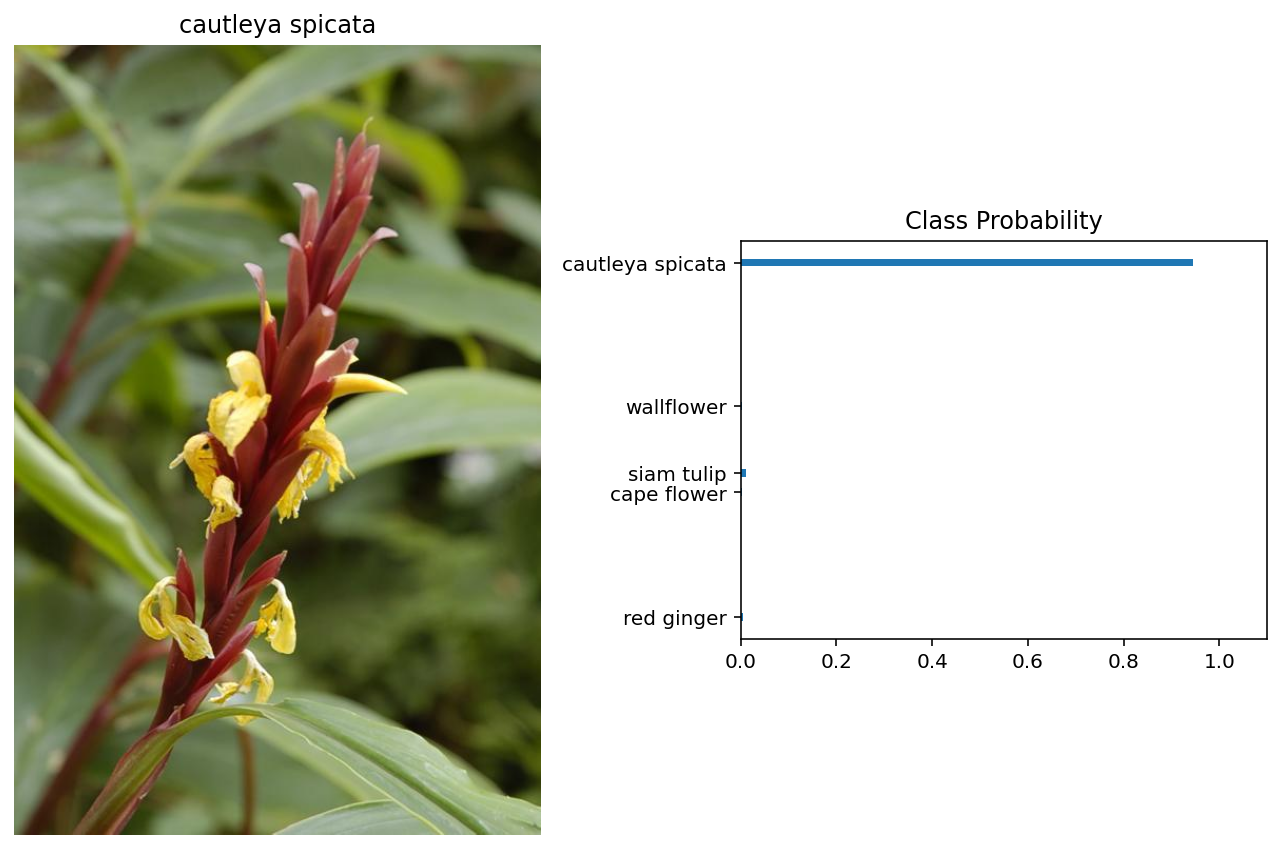

/content/drive/MyDrive/test_images/orange_dahlia.jpg
The 'probs' are:  [[0.86868376 0.02684225 0.02561459 0.01974828 0.00840778]]
The 'classes' are:  [[58 40 65  4 70]]
Class names:
- orange dahlia
- barbeton daisy
- osteospermum
- english marigold
- gazania


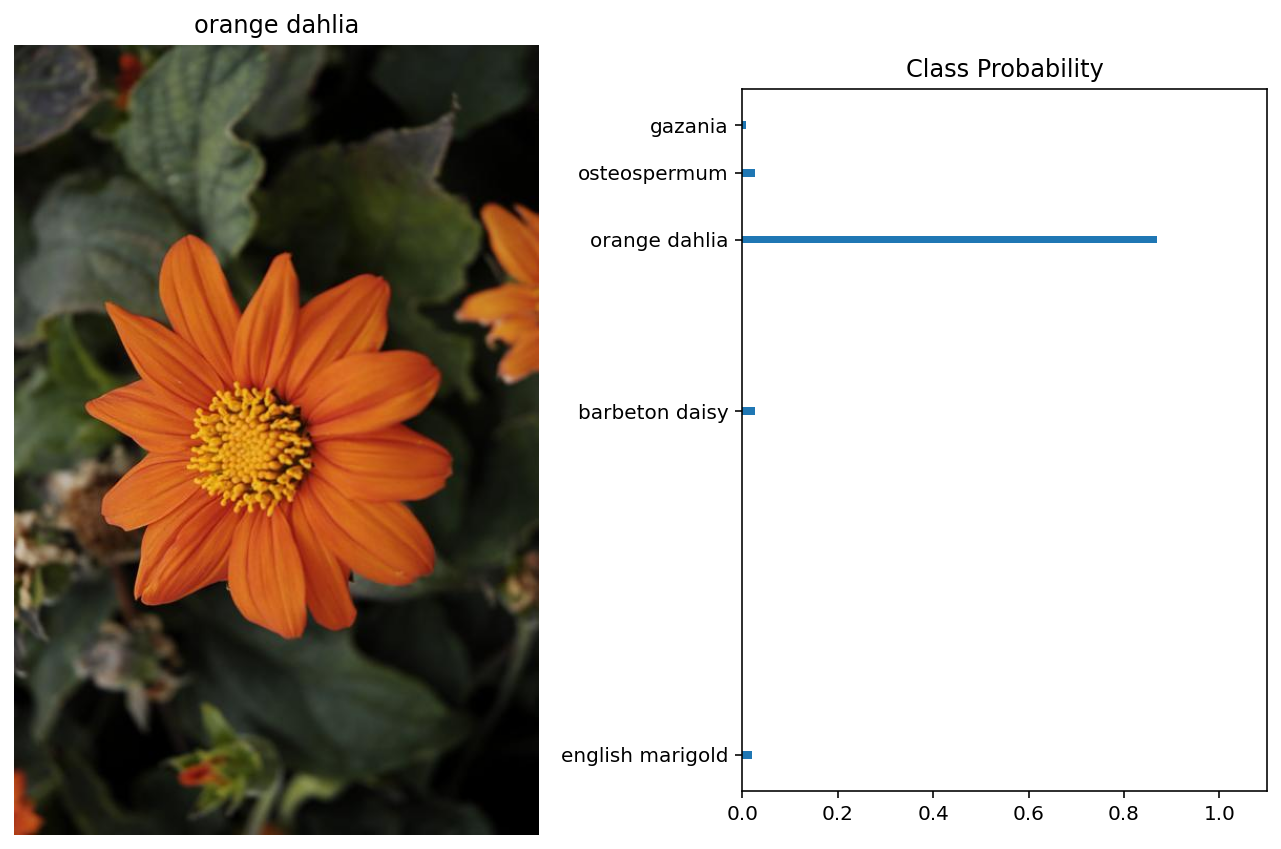

In [184]:
# Call the 'predict' function and plot the results.

import glob
import cv2

for image in glob.glob('/content/drive/MyDrive/test_images/*'):
  
  print(image)
  test_images = cv2.imread(image)
  test_images = cv2.cvtColor(test_images, cv2.COLOR_BGR2RGB)
  
  top_k_values, top_k_indices = predict(test_images, reloaded_keras_model, 5)

  flower_names = []
  print("Class names:")

  for idx in top_k_indices[0]:

    #top_k_indices = list(top_k_indices)
    #print(top_k_indices)
    
    print("-", class_names[str(idx + 1)])
    flower_names.append(class_names[str(idx + 1)])

  fig, (ax1, ax2) = plt.subplots(figsize = (9, 15), ncols=2)

  ax1.imshow(test_images)
  ax1.axis('off')
  ax1.set_title(flower_names[0])

  ax2.barh(top_k_indices[0], top_k_values[0])
  ax2.set_aspect(0.02)
  ax2.set_yticks(top_k_indices[0])
  ax2.set_yticklabels(flower_names);
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()
  plt.show()


In [185]:
# Convert to Html
!pip -q install nbconvert 

In [186]:
!jupyter nbconvert --to html image_classifier.ipynb


[NbConvertApp] WARNING | pattern 'image_classifier.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execut